# Load Model

In [ ]:
import numpy as np
import os

import torch
import torch.nn.functional as F
from KDLAE_model import KDLAE_teacher
from skimage import img_as_ubyte
from glob import glob
import cv2


weights_path = 'weights/KDLAE_T.pth'
weights_path = 'weights/KDLAE_T_L2Dice.pth' # denoise_rate = 0.6 

model_restoration = KDLAE_teacher(
    inp_channels=3,
    out_channels=3,
    dim=48,
    num_blocks=[4, 6, 6, 8],
    num_refinement_blocks=4,
    heads=[1, 2, 4, 8],
    ffn_expansion_factor=2.66,
    bias=False,
    LayerNorm_type="BiasFree",
    dual_pixel_task=False,
    static="train",
    params="cat"  # 'cat', 'plus', or 'mul' for different parameter handling
)

checkpoint = torch.load(weights_path)
model_restoration.load_state_dict(checkpoint['params'])
print("===>Testing using weights: ",weights_path)

# Specify the GPU device
device = torch.device("cuda:0")  # Here, "cuda:0" is the device identifier for the first GPU
model_restoration.to(device)  # Move the model to the specified GPU

model_restoration.eval()

===>Testing using weights:  weights/KDLAE_T_L2Dice.pth


KDLAE_teacher(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=254, bias=False)
        (project_out): Conv2d(127, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBloc

# Set denoise rate

In [ ]:

import random
denoise_rate = random.uniform(0, 1.0)  

denoise_rate = 1 
print(f"denoise_rate: {denoise_rate}")  


denoise_rate: 0.6


# Predict

Randomly chosen image: ../Sample/WDD/origin/0008_sort.jpg
input_ shape: torch.Size([1, 3, 664, 440]), alpha shape: torch.Size([1, 1, 664, 440])
restored shape: (658, 438, 3), dtype: uint8


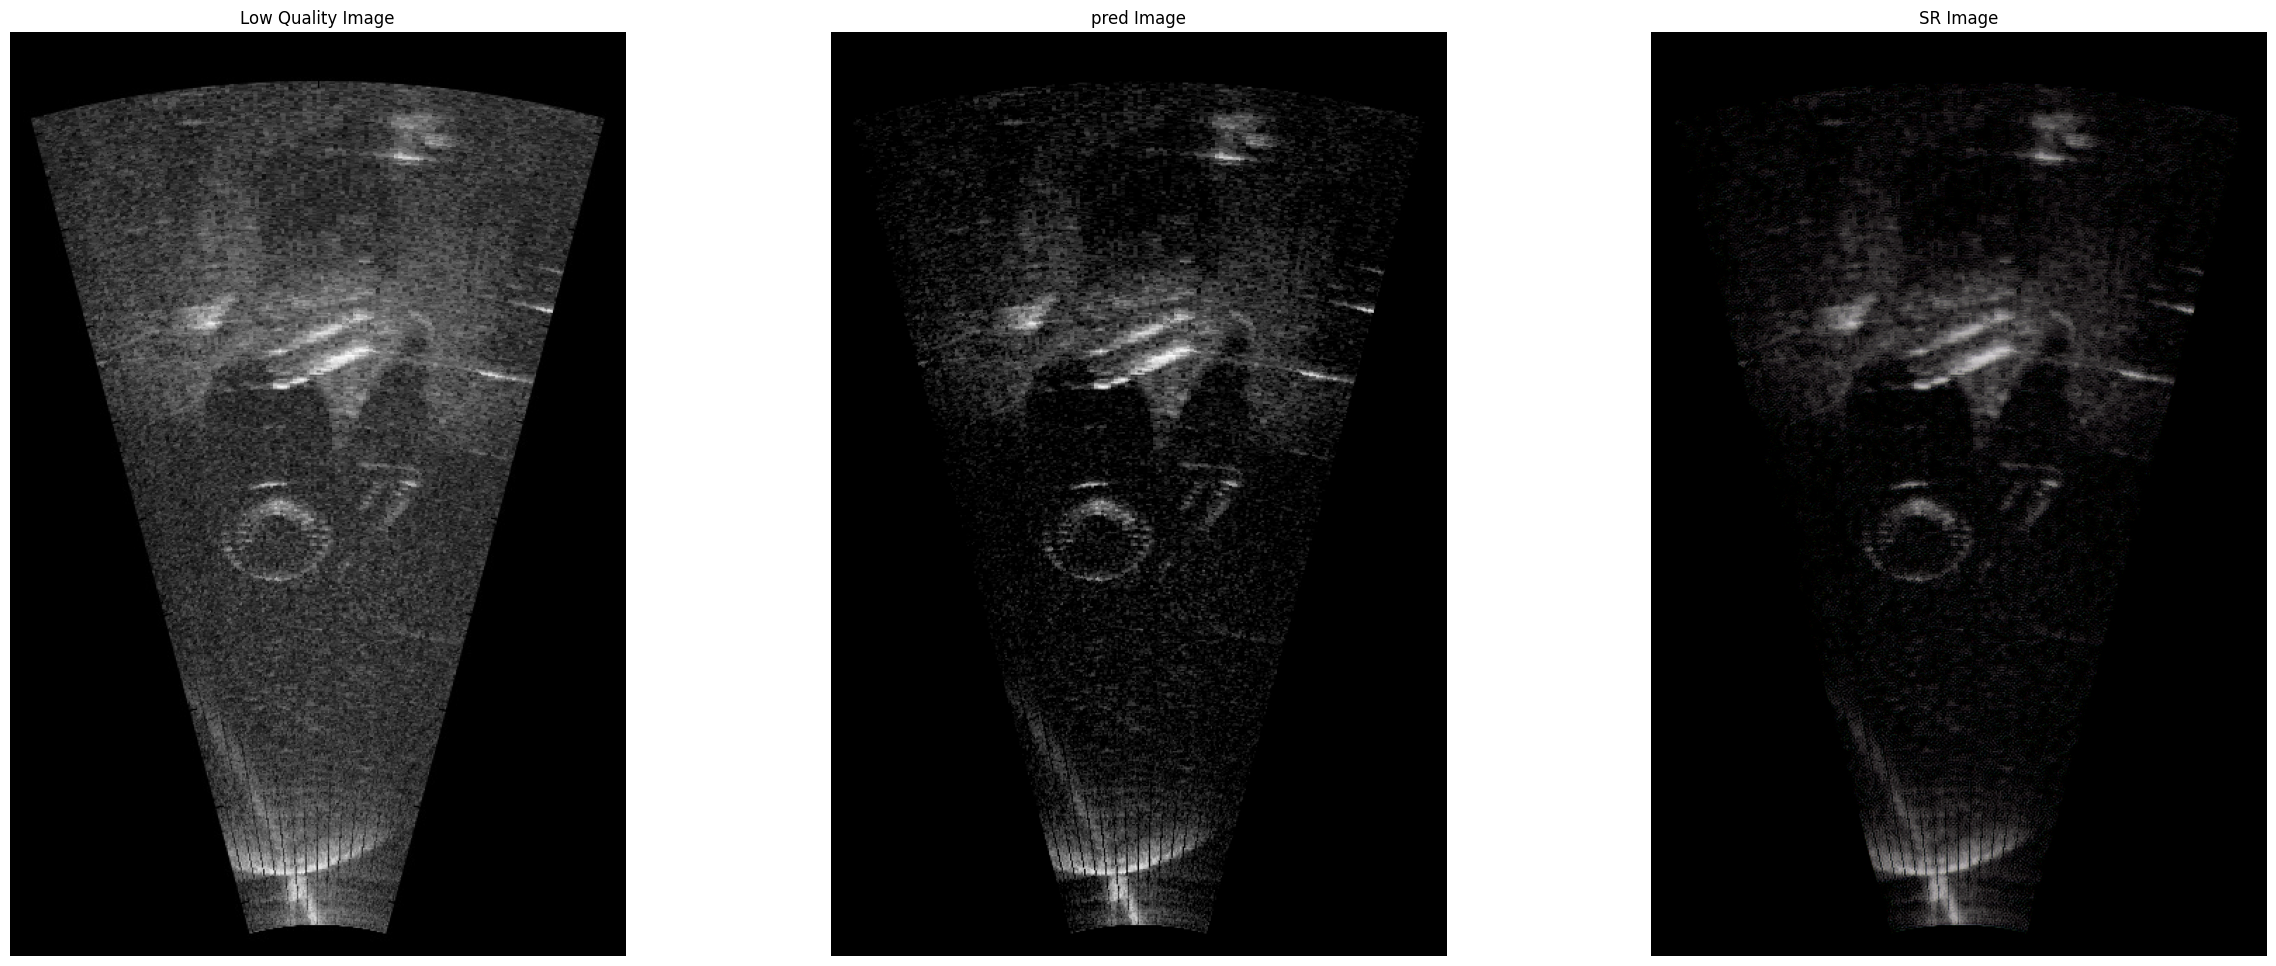

In [ ]:

import matplotlib.pyplot as plt
import random
plotflag = True    
# 配置参数
opt = {
    'dataroot_lq': '../Sample/WDD/origin',
}
img_multiple_of = 8
"""
直接随机读取图片为tensor，不经过标准的DataLoader。
"""

lq_dir = opt['dataroot_lq']
exts = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff']
lq_files = []
for e in exts:
    lq_files.extend(glob(os.path.join(lq_dir, e)))

assert len(lq_files) > 0, f"No images found in {lq_dir}"

# Random choose image
idx = random.randint(0, len(lq_files) - 1)
lq_path = lq_files[idx]
print(f"Randomly chosen image: {lq_path}")


def load_image_as_tensor(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    assert img is not None, f"Failed to read image: {path}"

    if img.ndim == 2:
        img = img[:, :, None]
    if img.shape[2] == 4:
        img = img[:, :, :3]
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    return tensor

with torch.no_grad():
    lq_images = load_image_as_tensor(lq_path).to(device)

    input_ = lq_images.float()
    h, w = input_.shape[2], input_.shape[3]
    H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
    padh = H-h if h % img_multiple_of != 0 else 0
    padw = W-w if w % img_multiple_of != 0 else 0
    input_ = F.pad(input_, (0, padw, 0, padh), 'reflect')


    alpha = torch.ones((1, 1, input_.shape[2], input_.shape[3]), device=device) * denoise_rate

    print(f"input_ shape: {input_.shape}, alpha shape: {alpha.shape}")
    input_ = {
        'img': input_,
        'denoise_rate': alpha.to(device)
    }
    # with autocast():
    pred = model_restoration(input_)

    restored = pred['hq']
    restored_sr = pred['sr']

    restored = torch.clamp(restored, 0, 1)
    restored_sr = torch.clamp(restored_sr, 0, 1)


    restored = restored[:, :, :h, :w]
    restored_sr = restored_sr[:, :, : (h * 2), : (w * 2)]


    restored_np = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
    restored_np = img_as_ubyte(restored_np[0])
    print(f"restored shape: {restored_np.shape}, dtype: {restored_np.dtype}")

    lq_np = lq_images.permute(0, 2, 3, 1).cpu().detach().numpy()[0]
    lq_ubyte = img_as_ubyte(lq_np)
    if lq_ubyte.shape[-1] == 3:
        mask = (lq_ubyte[..., 0] == 0) & (lq_ubyte[..., 1] == 0) & (lq_ubyte[..., 2] == 0)
    else:
        mask = (lq_ubyte.squeeze() == 0)
    restored_np[mask] = 0

    mask_sr = np.repeat(np.repeat(mask, 2, axis=0), 2, axis=1)
    restored_sr_np = restored_sr.permute(0, 2, 3, 1).cpu().detach().numpy()
    restored_sr_np = img_as_ubyte(restored_sr_np[0])
    restored_sr_np[mask_sr] = 0

    def prepare_image(tensor):
        return tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    if plotflag:
        plt.figure(figsize=(30, 12))
        plt.subplot(1, 3, 1)
        plt.imshow(prepare_image(lq_images), cmap='gray')
        plt.title('Low Quality Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        restored_np = cv2.cvtColor(restored_np, cv2.COLOR_BGR2GRAY) # for L2_dice
        plt.imshow(restored_np, cmap='gray')
        plt.title('pred Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        restored_sr_np = cv2.cvtColor(restored_sr_np, cv2.COLOR_BGR2GRAY) # for L2_dice
        plt.imshow(restored_sr_np, cmap='gray')
        plt.title('SR Image')
        plt.axis('off')


    